In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten,Conv2D,Input,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Data generator

In [15]:
root_path = r"E:\deep_learning\skin_cancer\dataset\dataset"
img_width,img_height = 128,128
model_input = (img_width,img_height,3)
img_size = (img_width,img_height)
batch_size = 32

In [16]:


_datagen = ImageDataGenerator(
        rescale=1/255,
		width_shift_range=0.1,
		height_shift_range=0.1,
		horizontal_flip=True)

train_gen = _datagen.flow_from_directory(
    root_path+"/train",
    target_size = img_size,
    batch_size=batch_size,
    class_mode = "categorical"
)


test_gen = _datagen.flow_from_directory(
    root_path+"/test",
    target_size = img_size,
    batch_size=batch_size,
    class_mode = "categorical"
)

Found 2967 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


#### Create model

In [17]:
from pyexpat import model
from statistics import mode


def create_model(input_size,kernel_size,num_filter,num_conv_layer,num_output):
    model = Sequential(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu',input_shape =input_size ))
    for i in range(num_conv_layer):
        model.add(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu'))
        model.add(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu'))

        model.add(MaxPooling2D(2, 2))
        num_filter= num_filter+num_filter
    model.add(Flatten())
    model.add(Dense(units = num_output,activation = "softmax"))
    return model

#### Parameter and train

In [18]:
conv_layers = 2
num_filter = 32
kernel_size = (3,3)
num_train = len(train_gen.filenames)
num_test = len(test_gen.filenames)
steps_per_epoch=int(num_train / batch_size)

epochs =3


In [19]:
model = create_model(input_size= model_input,
                kernel_size = kernel_size,
                num_filter=num_filter,
                num_conv_layer = conv_layers,
                num_output=3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [20]:


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [21]:
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,
                            validation_data=test_gen,
                            validation_steps=int(num_test / batch_size))

Epoch 1/3


C:\Users\tharh\AppData\Local\Temp\ipykernel_11364\1490670082.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,


92/92 [==============================] - 13s 136ms/step - loss: 0.7690 - accuracy: 0.6361 - val_loss: 0.7088 - val_accuracy: 0.7000
Epoch 2/3
92/92 [==============================] - 13s 137ms/step - loss: 0.6093 - accuracy: 0.7199 - val_loss: 0.7007 - val_accuracy: 0.6812
Epoch 3/3
92/92 [==============================] - 13s 140ms/step - loss: 0.5284 - accuracy: 0.7642 - val_loss: 0.5894 - val_accuracy: 0.7344


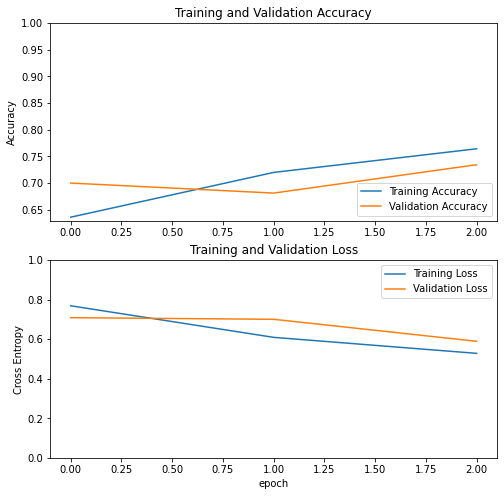

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
print("Evaluate on test data")
results = model.evaluate(test_gen , batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
11/11 [==============================] - 2s 136ms/step - loss: 0.5866 - accuracy: 0.7303
test loss, test acc: [0.586582601070404, 0.7303030490875244]


In [37]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [38]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [39]:
def objective(params):
    with mlflow.start_run():  
        mlflow.set_tag("developer","tharhtet")
        mlflow.log_params(params)


        model = create_model(input_size= model_input,
                kernel_size = params["kernel_size"],
                num_filter=params["filter_size"],
                num_conv_layer = params["conv_layers"],
                num_output=3)
        
        model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=params["learning_rate"]),
                    metrics=['accuracy'])
        results = model.evaluate(test_gen , batch_size=15)
        mlflow.log_metric("val_loss", results[0])
        mlflow.log_metric("val_acc", results[1])
    return {'loss' :results[0],'status':STATUS_OK }

        

In [40]:
conv_layers = 2
filters_size = [16,32,64,128]
kernel_sizes= [(3,3),(5,5),(7,7)]
learning_rate = 0.001
epochs =3



search_space = {
    "conv_layers" : scope.int(hp.quniform("conv_layers",2,10,1)),
    "filter_size" : scope.int(hp.choice("filter_size",filters_size)),
    "kernel_size" : hp.choice("kernel_size",kernel_sizes),
    "learning_rate" : hp.loguniform("learning_rate",-3,0),
    "epochs" : scope.int(hp.quniform("epochs",2,10,1))
    

}

In [41]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

{'conv_layers': 6, 'epochs': 2, 'filter_size': 64, 'kernel_size': (5, 5), 'learning_rate': 0.30267259332058205}
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

c:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



11/11 [==============================] - 5s 234ms/step - loss: 1.0986 - accuracy: 0.3455

{'conv_layers': 4, 'epochs': 4, 'filter_size': 64, 'kernel_size': (7, 7), 'learning_rate': 0.1316097171131269}
11/11 [==============================] - 4s 186ms/step - loss: 1.0986 - accuracy: 0.3333

100%|██████████| 2/2 [00:10<00:00,  5.29s/trial, best loss: 1.09856116771698]  
